In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import capstone.portfolio.optimize as opt
from capstone.portfolio.prune import prune_allocations
from capstone.portfolio.backtest import backtest_portfolios
from capstone.portfolio.metrics import Metrics

from capstone.utils import read_file, get_sectors
from tqdm.auto import tqdm

sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [49]:
sectors = get_sectors()
stocks_by_sector = read_file("stocks_by_sector", index_col=0)

snp_log_returns = read_file("snp_log_returns", index_col=0)

sarimax_ouls = read_file("sarimax_mean_ouls", index_col=0)
sklearn_ouls = read_file("sklearn_mean_ouls", index_col=0)

sarimax_best_sectors = read_file("sarimax_best_sectors", index_col=0)
sklearn_best_sectors = read_file("model_preds", index_col=0)

In [45]:
best_sectors_by_model = pd.concat([sarimax_best_sectors, sklearn_best_sectors], axis=1)
best_sectors_by_model = best_sectors_by_model.dropna()

best_sectors_by_model.head()

,SARIMAX,ElasticNet,SVR,RandomForest,GradientBoost,XGBoost
2007-11-20,FINANCIALS,ENERGY,INDUSTRIALS,ENERGY,INFORMATION_TECHNOLOGY,UTILITIES
2008-05-22,CONSUMER_DISCRETIONARY,ENERGY,CONSUMER_DISCRETIONARY,ENERGY,UTILITIES,UTILITIES
2008-11-19,FINANCIALS,CONSUMER_STAPLES,UTILITIES,REAL_ESTATE,REAL_ESTATE,CONSUMER_STAPLES
2009-05-22,FINANCIALS,CONSUMER_DISCRETIONARY,UTILITIES,REAL_ESTATE,REAL_ESTATE,REAL_ESTATE
2009-11-19,INFORMATION_TECHNOLOGY,REAL_ESTATE,INDUSTRIALS,INFORMATION_TECHNOLOGY,COMMUNICATION_SERVICES,CONSUMER_DISCRETIONARY


In [46]:
mean_ouls = pd.concat([sarimax_ouls, sklearn_ouls], axis=1)
mean_ouls = mean_ouls.dropna()

mean_ouls.head()

,SARIMAX,ElasticNet,SVR,RandomForest,GradientBoost,XGBoost
2007-11-20,0.089489,0.096306,0.105168,0.094162,0.096791,0.105649
2008-05-22,0.099027,0.116511,0.115252,0.117599,0.122813,0.127769
2008-11-19,0.108878,0.133420,0.131496,0.131363,0.137950,0.137811
2009-05-22,0.156493,0.143494,0.200317,0.142633,0.135784,0.138641
2009-11-19,0.112607,0.095587,0.116406,0.098575,0.113076,0.102603


In [48]:
best_models = mean_ouls.idxmin(axis=1)
best_models.head()

2007-11-20          SARIMAX
2008-05-22          SARIMAX
2008-11-19          SARIMAX
2009-05-22    GradientBoost
2009-11-19       ElasticNet
dtype: object

In [50]:
forecast = 126

# Create an empty DataFrame
results = pd.DataFrame(
    columns=["SELECTED_MODEL", "SELECTED_SECTOR", "AVAILABLE_STOCKS"],
    index=best_models.index
)

# Loop through dates in the best_models index
for date in best_models.index:

    # Get the best model for the current date
    best_model = best_models.loc[date]

    # Predict the selected sector using the best model
    selected_sector = best_sectors_by_model.loc[date, best_model]

    # Store the selected model and sector in the results DataFrame
    results.loc[date, "SELECTED_MODEL"] = best_model
    results.loc[date, "SELECTED_SECTOR"] = selected_sector

    # Retrieve the selected sector's constituents from stocks_by_sector DataFrame
    sector_constituents = stocks_by_sector[stocks_by_sector["GICS Sector"] == selected_sector]["Symbol"]

    # Filter out constituents that are not in snp_log_returns columns
    sector_constituents = [c for c in sector_constituents if c in snp_log_returns.columns]

    # Store the available stocks as a space-separated string
    results.loc[date, "AVAILABLE_STOCKS"] = ' '.join(sector_constituents)

# Split the space-separated stock symbols into an array
results["AVAILABLE_STOCKS"] = results["AVAILABLE_STOCKS"].apply(lambda s: np.array(s.split()))

In [51]:
# Get unique available stocks from the results DataFrame
available_stocks = results.explode("AVAILABLE_STOCKS")['AVAILABLE_STOCKS'].unique()

# Create DataFrames to store allocations for different strategies
ms_allocations = pd.DataFrame(columns=available_stocks, index=results.index)
mv_allocations = pd.DataFrame(columns=available_stocks, index=results.index)
rp_allocations = pd.DataFrame(columns=available_stocks, index=results.index)

# Initialize columns for Sharpe ratios in the results DataFrame
results[["EW_SHARPE", "MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = np.nan

# Loop through dates in the results index
for date in tqdm(results.index):

    # Get selected stocks for the current date
    selected_stocks = results.loc[date, "AVAILABLE_STOCKS"]

    # Retrieve past returns for selected stocks within the forecast window
    past_returns = snp_log_returns[selected_stocks].loc[:date][-forecast:]

    # Initialize equal-weighted portfolio weights
    weights = np.array([1/len(selected_stocks)] * len(selected_stocks))

    # Calculate and store the Equal-Weighted (EW) Sharpe ratio
    results.at[date, "EW_SHARPE"] = opt.port_sharpe(weights, past_returns)

    # Calculate the Maximum Sharpe (MS) and Minimum Variance (MV) portfolios
    ms_w, ms_s = opt.max_sharpe_opt(weights, past_returns)
    mv_w, mv_s = opt.min_var_opt(weights, past_returns)

    # Calculate and store the Risk Parity (RP) portfolio
    rp_w, rp_s = opt.risk_parity_opt(weights, past_returns)

    # Store allocations for each strategy
    ms_allocations.loc[date, selected_stocks] = ms_w
    mv_allocations.loc[date, selected_stocks] = mv_w
    rp_allocations.loc[date, selected_stocks] = rp_w

    # Store Sharpe ratios for MS, MV, and RP strategies
    results.loc[date, ["MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = [ms_s, mv_s, rp_s]

# Drop the "AVAILABLE_STOCKS" column from the results DataFrame and display the first few rows
results.drop("AVAILABLE_STOCKS", axis=1).head()

100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


,SELECTED_MODEL,SELECTED_SECTOR,EW_SHARPE,MS_SHARPE,MV_SHARPE,RP_SHARPE
2007-11-20,SARIMAX,FINANCIALS,-0.948183,3.303606,1.274199,-0.827613
2008-05-22,SARIMAX,CONSUMER_DISCRETIONARY,-0.371399,1.631071,-0.329665,-0.415744
2008-11-19,SARIMAX,FINANCIALS,-2.036696,-0.014827,-1.313341,-1.950199
2009-05-22,GradientBoost,REAL_ESTATE,0.479045,1.756863,1.331186,0.598533
2009-11-19,ElasticNet,REAL_ESTATE,1.792080,3.182959,1.885873,1.902636


In [52]:
# Prune the allocation DataFrames (ms_allocations, mv_allocations, rp_allocations)
# by removing weights below a minimum weight threshold of 0.01 and re-normalizing the remaining weights.
ms_allocations, mv_allocations, rp_allocations = prune_allocations(
    ms_allocations, mv_allocations, rp_allocations, min_weight_th=0.01 
)

In [53]:
# Select constituent returns based on columns in ms_allocations
constituent_returns = snp_log_returns[ms_allocations.columns]

# Backtest portfolios for MS, MV, and RP strategies using the specified allocations
ms_port_rets, mv_port_rets, rp_port_rets = backtest_portfolios(
    ms_allocations, 
    mv_allocations, 
    rp_allocations, 
    constituent_returns=constituent_returns
)

# Calculate the equal-weighted portfolio returns by taking the mean of constituent returns
ew_port_rets = constituent_returns.sum(axis=1) / len(constituent_returns.columns)

# Reindex the equal-weighted portfolio returns to match the other portfolio returns' index
ew_port_rets = ew_port_rets.reindex(ms_port_rets.index)

# Set the return at the earliest date to 0 for consistency
ew_port_rets.loc[ew_port_rets.index.min()] = 0

In [54]:
# Concatenate the portfolio returns (ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets) horizontally
port_rets = pd.concat([ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets], axis=1)

# Rename the columns to describe each portfolio strategy
port_rets.columns = ["ONE_OVER_N", "MAX_SHARPE", "MIN_VAR", "RISK_PARITY"]

# Create an instance of the Metrics class
portfolio_metrics = Metrics()

# Calculate portfolio metrics (e.g., mean return, volatility, Sharpe ratio) using the Metrics class
portfolio_metrics.calculate(port_rets)

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.351758,1.640007,0.103892,0.295351
ONE_OVER_N,0.403531,1.458024,0.092364,0.228888
RISK_PARITY,0.246316,1.094788,0.069353,0.281562
MIN_VAR,0.236613,0.813597,0.051540,0.217824


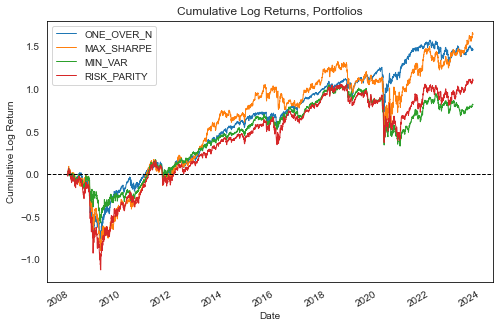

In [56]:
# Plot cumulative returns of each portfolio
port_rets.cumsum().plot(figsize=(8, (8*(2/3))), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns, Portfolios")
plt.ylabel("Cumulative Log Return")
plt.show()

In [57]:
# Compare the best portfolio with sector returns
sector_metrics = Metrics()

best_portfolio = portfolio_metrics.metrics['Cumulative Return'].idxmax()
sector_returns_reindexed = df[sectors].reindex(port_rets.index).copy()
sector_returns_reindexed.loc[sector_returns_reindexed.index.min()] = 0
sector_comparison = pd.concat([port_rets[best_portfolio], sector_returns_reindexed], axis=1)
sector_metrics.calculate(sector_comparison)[:5]

NameError: name 'df' is not defined

In [ ]:
# Compare best portfolio to S&P 500
SPY_metrics = Metrics()

# Load SPY prices
SPY_log_rets = read_file("spy_log_returns", "data", index_col="Date")
SPY_log_rets.columns = ["SPY"]

# Combine SPY returns and best portfolo returns into a dataframe for comparison
spy_comparison = pd.concat([port_rets[best_portfolio], SPY_log_rets], axis=1)
spy_comparison.cumsum().plot(figsize=(8, (8*(2/3))), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns")
plt.ylabel("Cumulative Log Return")
plt.show()

In [ ]:
# Inspect portfolio metrics against SPY
SPY_metrics.calculate(spy_comparison)